In [1]:
import numpy as np 
import pandas as pd 
import collections
from tqdm import tqdm
from scipy.sparse import csr_matrix, save_npz, load_npz, hstack
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt

In [2]:
answers = pd.read_csv('answers.csv')
questions = pd.read_csv('questions.csv')
tags = pd.read_csv('tags.csv')
users = pd.read_csv('users.csv')

/Users/kiwi/anaconda3/envs/ids/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def get_user_qtag_matrix():
    user_num = len(users)
    tags_num = len(tags)
    
    shape = (user_num, tags_num)
    rows, cols = user_num, tags_num
    data = []

    for i in tqdm(range(user_num)):
        user_id = users['id'].iloc[i]
        questions_tags = questions[questions['owner_user_id']==user_id]['tags'].to_list()
        tags_dict = collections.Counter()
        for q in questions_tags:
            q = str(q)
            for ele in q.split('|'):
                tags_dict[ele]+=1
    
        for t in tags_dict:
            data.append([user_id, t, tags_dict[t]])

            
    df = pd.DataFrame(data, columns = ['uid', 'tag', 'value']) 
    df = df.pivot_table(index = "uid", columns = "tag", values = 'value')
    df = df.fillna(0)
    
    return df
user_qtag_matrix = get_user_qtag_matrix()

100%|██████████| 21209/21209 [00:19<00:00, 1096.59it/s]


In [4]:
def get_user_atag_matrix():
    user_num = len(users)
    tags_num = len(tags)
    
    shape = (user_num, tags_num)
    rows, cols = user_num, tags_num
    data = []

    for i in tqdm(range(user_num)):
        user_id = users['id'].iloc[i]
        tags_dict = collections.Counter()
        answered_questions = answers[answers['uid']==user_id]['qtags'].to_list()
        
        for a in answered_questions:
            a = str(a)
            for ele in a.split('|'):
                tags_dict[ele]+=1
        
        for t in tags_dict:
            data.append([user_id, t, tags_dict[t]])

            
    df = pd.DataFrame(data, columns = ['uid', 'tag', 'value']) 
    df = df.pivot_table(index = "uid", columns = "tag", values = 'value')
    df = df.fillna(0)    
    return df
user_atag_matrix = get_user_atag_matrix()

100%|██████████| 21209/21209 [00:24<00:00, 853.17it/s] 


In [5]:
def save_user_tag(user_tag_matrix, output_name):
    users_id = users.loc[:, ['id']]
    user_tag_matrix = user_tag_matrix.drop(['uid'], axis=1)
    matrix = users_id.merge(user_tag_matrix, left_on = "id", right_on = "uid", how = "left")
    matrix = matrix.fillna(0)
    matrix = matrix.iloc[:, 1:].to_numpy()
    save_npz(output_name, csr_matrix(matrix))
    
save_user_tag(user_atag_matrix, "user_atag.npz")
save_user_tag(user_qtag_matrix, "user_qtag.npz")

In [6]:
user_atag_matrix = load_npz("user_atag.npz")
user_qtag_matrix = load_npz("user_qtag.npz")

In [7]:
def calc_similarity(qtag, atag):
    features = hstack([qtag, atag])
    return cosine_similarity(features)

In [10]:
similarity = calc_similarity(user_qtag_matrix, user_atag_matrix)
save_npz("sim.npz", csr_matrix(similarity))

In [11]:
sequenced_sim = similarity[np.triu_indices(len(similarity), k = 1)]

(array([2.14926413e+08, 5.03659300e+06, 2.35184900e+06, 1.23178400e+06,
        6.87706000e+05, 3.52612000e+05, 1.79621000e+05, 9.05620000e+04,
        3.44440000e+04, 8.65200000e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

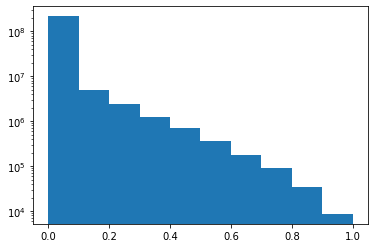

In [12]:
plt.hist(sequenced_sim, log=True)

In [13]:
def get_similar_users(similarity, users, user_id, top=5, threshold=-1):
    u_index = users.index[users['id'] == user_id].tolist()[0]
    arr = similarity[u_index]
    idx, = np.where(arr >= threshold)
    similar_index = idx[np.argsort(arr[idx])[-(top + 1):-1][::-1]]
    similar_ids = users.loc[list(similar_index), ['id', 'display_name']]
    return similar_ids

similar = get_similar_users(similarity, users, 3460, top=5)

In [14]:
similar

,id,display_name
13395,105460,zsalzbank
6065,163769,Liam
6211,245163,Brendan
5926,65763,Parrots
448,207287,David


In [15]:
def calc_affinity(qtag, atag):
    '''TODO: merge tags of questions and answers'''
    return 